In [1]:
import pandas as pd
from csvCreator import get_readable_date
import numpy as np

In [2]:
def to_evenly_spaced(df):
    date = df['time'].apply(lambda x: get_readable_date(x))
    df.insert(loc=1, column='date', value=date)
    median = np.trunc(df.groupby('date').size().median())
    df.drop(['date'], axis=1, inplace=True)
    day = np.trunc(len(df.index) / median)
    new_last_index = int(median * day)

    df.drop(['time'], axis=1, inplace=True)
    df = df.iloc[:new_last_index]
    return df.drop(['phq_2'], axis=1), df.drop(['phq_1'], axis=1), int(median)

In [3]:
def generator(data, look_b, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + look_b
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + look_b, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + look_b
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           look_b // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_b, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets


In [4]:
output_path = '/Volumes/hex/ST-1233329802-res/'
p_802 = pd.read_csv(output_path + 'ST-1233329802_3.0.csv')

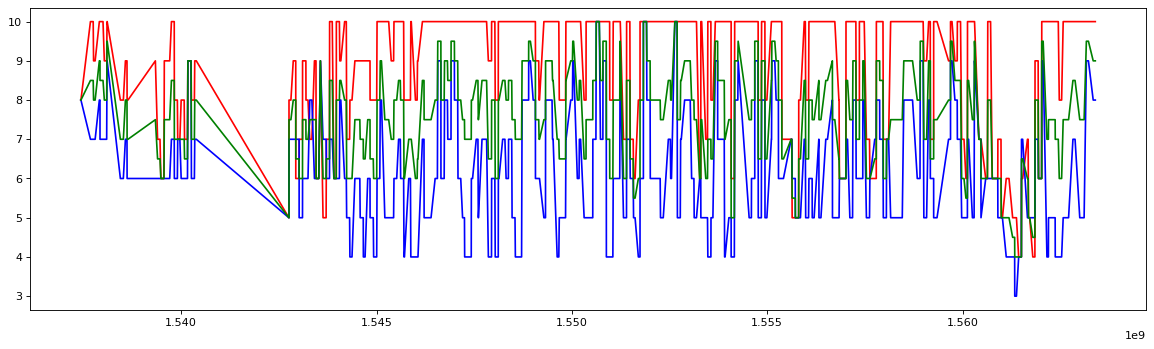

In [5]:
from matplotlib import pyplot
%matplotlib inline
xaxis = p_802[['time']]
yaxis = p_802[['phq_1']]
yaxis2 = p_802[['phq_2']]
avg = p_802[['phq_1', 'phq_2']].mean(axis=1)
fig=pyplot.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
pyplot.plot(xaxis, yaxis, color='red', label='phq_1')
pyplot.plot(xaxis, yaxis2, color='blue', label='phq_2')
pyplot.plot(xaxis, avg, color='green', label='avg')

In [6]:
p_802.head()

,time,date,window,accX,accX_std,accY,accY_std,accZ,accZ_std,gyrX,...,ple_std,mood,tense,tired,rumination,socialize,socialize_val,work_time,phq_1,phq_2
0,1537427588,20.09.18,60,-2.63,5.72,-6.09,3.42,2.21,3.42,-3.86,...,504679.50,2,4,1,4,37,49,240,8,8
1,1537427648,20.09.18,59,-4.04,3.80,-6.98,2.31,-0.86,2.31,-1.44,...,209617.92,2,4,1,4,37,49,240,8,8
2,1537427707,20.09.18,60,0.35,1.45,-9.31,0.81,-3.01,0.81,0.03,...,110861.97,2,4,1,4,37,49,240,8,8
3,1537427767,20.09.18,120,-4.51,4.72,-6.16,2.57,1.07,2.57,-0.40,...,242204.13,2,4,1,4,37,49,240,8,8
4,1537427887,20.09.18,3585,6.36,5.85,-1.83,4.15,0.67,4.15,3.50,...,689277.46,2,4,1,4,37,49,240,8,8


In [7]:
# just numerical data
p_802 = p_802.drop(['date', 'window'], axis=1)
p_802_1, p_802_2, median = to_evenly_spaced(p_802)

In [8]:
float_data_1 = p_802_1.to_numpy()
p_802_1.head()

,accX,accX_std,accY,accY_std,accZ,accZ_std,gyrX,gyrX_std,gyrY,gyrY_std,...,PlethysmogramGreen,ple_std,mood,tense,tired,rumination,socialize,socialize_val,work_time,phq_1
0,-2.63,5.72,-6.09,3.42,2.21,3.42,-3.86,79.85,-3.27,46.53,...,2165277.05,504679.50,2,4,1,4,37,49,240,8
1,-4.04,3.80,-6.98,2.31,-0.86,2.31,-1.44,80.40,2.52,35.61,...,2228357.74,209617.92,2,4,1,4,37,49,240,8
2,0.35,1.45,-9.31,0.81,-3.01,0.81,0.03,20.70,0.09,16.15,...,1888259.33,110861.97,2,4,1,4,37,49,240,8
3,-4.51,4.72,-6.16,2.57,1.07,2.57,-0.40,102.96,-0.84,34.28,...,2214220.42,242204.13,2,4,1,4,37,49,240,8
4,6.36,5.85,-1.83,4.15,0.67,4.15,3.50,92.47,0.54,82.14,...,2712535.35,689277.46,2,4,1,4,37,49,240,8


In [9]:
float_data_2 = p_802_2.to_numpy()
p_802_2.head()

,accX,accX_std,accY,accY_std,accZ,accZ_std,gyrX,gyrX_std,gyrY,gyrY_std,...,PlethysmogramGreen,ple_std,mood,tense,tired,rumination,socialize,socialize_val,work_time,phq_2
0,-2.63,5.72,-6.09,3.42,2.21,3.42,-3.86,79.85,-3.27,46.53,...,2165277.05,504679.50,2,4,1,4,37,49,240,8
1,-4.04,3.80,-6.98,2.31,-0.86,2.31,-1.44,80.40,2.52,35.61,...,2228357.74,209617.92,2,4,1,4,37,49,240,8
2,0.35,1.45,-9.31,0.81,-3.01,0.81,0.03,20.70,0.09,16.15,...,1888259.33,110861.97,2,4,1,4,37,49,240,8
3,-4.51,4.72,-6.16,2.57,1.07,2.57,-0.40,102.96,-0.84,34.28,...,2214220.42,242204.13,2,4,1,4,37,49,240,8
4,6.36,5.85,-1.83,4.15,0.67,4.15,3.50,92.47,0.54,82.14,...,2712535.35,689277.46,2,4,1,4,37,49,240,8


In [10]:
median

452

In [11]:
# first 200 days as training
mean = float_data_1[:90400].mean(axis=0)
float_data_1 -= mean
std = float_data_1[:90400].std(axis=0)
float_data_1 /= std

In [12]:
# first 200 days as training
mean = float_data_2[:90400].mean(axis=0)
float_data_2 -= mean
std = float_data_2[:90400].std(axis=0)
float_data_2 /= std

In [13]:
float_data_1[0]

array([-1.22544612,  5.71048722, -0.6541132 ,  2.98587402, -0.21903021,
        2.98587402, -7.75446454,  6.0399647 , -9.30654744,  6.05167197,
       -1.92787682,  6.82925229, -1.37115884, 19.05504734, -2.70913572,
       -2.04544979, -2.10834643,  0.07319007, -0.26389235,  1.28103953,
       -0.45232897, -0.38280431, -0.19601194, -1.24393266,  1.37002538,
       -0.84318036])

In [14]:
float_data_2[0]

array([-1.22544612,  5.71048722, -0.6541132 ,  2.98587402, -0.21903021,
        2.98587402, -7.75446454,  6.0399647 , -9.30654744,  6.05167197,
       -1.92787682,  6.82925229, -1.37115884, 19.05504734, -2.70913572,
       -2.04544979, -2.10834643,  0.07319007, -0.26389235,  1.28103953,
       -0.45232897, -0.38280431, -0.19601194, -1.24393266,  1.37002538,
        1.24252768])

In [15]:
# assume each day got 452 value (average value) that means approx. 17 value per Hour.
# step per hour
step = int(np.trunc(60 / (median / 24)))
# observations will look back 7 days (average)
look_back = step * 7 * 24

# steps in the future to be predicted each time
delay = 24 * step

# one day
batch_size = median

In [16]:
step

3

In [17]:
# for phq-1
train_gen_1 = generator(float_data_1,
                      look_b=look_back,
                      delay=delay,
                      min_index=0,
                      max_index=90400,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen_1 = generator(float_data_1,
                    look_b=look_back,
                    delay=delay,
                    min_index=90401,
                    max_index=108480,
                    step=step,
                    batch_size=batch_size)
test_gen_1 = generator(float_data_1,
                     look_b=look_back,
                     delay=delay,
                     min_index=108481,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [18]:
# for phq-2
train_gen_2 = generator(float_data_2,
                      look_b=look_back,
                      delay=delay,
                      min_index=0,
                      max_index=90400,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen_2 = generator(float_data_2,
                    look_b=look_back,
                    delay=delay,
                    min_index=90401,
                    max_index=108480,
                    step=step,
                    batch_size=batch_size)
test_gen_2 = generator(float_data_2,
                     look_b=look_back,
                     delay=delay,
                     min_index=108481,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [19]:
# val_steps = (108480 - 90401 - look_back)
test_steps = (122040 - 108480)//batch_size
val_steps = (108480 - 90400)//batch_size
per_epoch =90400//batch_size
per_epoch

200

In [20]:
val_steps

40

In [21]:
test_steps

30

In [22]:
def evaluate_naive_model(v_gen):
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(v_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [23]:
evaluate_naive_model(val_gen_1)

1.1344340628348881


In [25]:
evaluate_naive_model(val_gen_2)

0.9302359435085247


In [236]:
temp = None

# One GRU layer Model for PHQ-1

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

In [39]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data_1.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimzer=RMSprop(), loss='mae')
history = model.fit(train_gen_1,
                    steps_per_epoch=per_epoch,
                    epochs=20,
                    validation_data=val_gen_1,
                    validation_steps=val_steps)


Train for 200 steps, validate for 40.0 steps
Epoch 1/20
200/200 [==============================] - 64s 322ms/step - loss: 0.2293 - val_loss: 0.1935
Epoch 2/20
200/200 [==============================] - 62s 308ms/step - loss: 0.1416 - val_loss: 0.1932
Epoch 3/20
200/200 [==============================] - 61s 303ms/step - loss: 0.1320 - val_loss: 0.1812
Epoch 4/20
200/200 [==============================] - 61s 307ms/step - loss: 0.1263 - val_loss: 0.1765
Epoch 5/20
200/200 [==============================] - 60s 301ms/step - loss: 0.1251 - val_loss: 0.1843
Epoch 6/20
200/200 [==============================] - 60s 298ms/step - loss: 0.1235 - val_loss: 0.1658
Epoch 7/20
200/200 [==============================] - 63s 314ms/step - loss: 0.1196 - val_loss: 0.1648
Epoch 8/20
200/200 [==============================] - 60s 301ms/step - loss: 0.1204 - val_loss: 0.1733
Epoch 9/20
200/200 [==============================] - 59s 295ms/step - loss: 0.1198 - val_loss: 0.1636
Epoch 10/20
200/200 [=======

In [68]:
model.save('model_1.h5') 

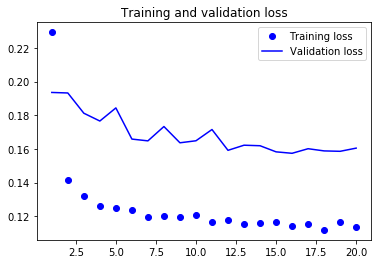

In [41]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [188]:
model.evaluate(test_gen, steps=30)

30/30 [==============================] - 3s 88ms/step - loss: 0.1710


0.1709733731423815

# for PHQ-2

In [237]:
model_1_2 = Sequential()
model_1_2.add(layers.GRU(32, input_shape=(None, float_data_2.shape[-1])))
model_1_2.add(layers.Dense(1))

model_1_2.compile(optimzer=RMSprop(), loss='mae')
history_1_2 = model_1_2.fit(train_gen_2,
                    steps_per_epoch=per_epoch,
                    epochs=20,
                    validation_data=val_gen_2,
                    validation_steps=val_steps)

Train for 200 steps, validate for 40 steps
Epoch 1/20
200/200 [==============================] - 71s 355ms/step - loss: 0.2853 - val_loss: 0.2110
Epoch 2/20
200/200 [==============================] - 59s 295ms/step - loss: 0.1925 - val_loss: 0.2126
Epoch 3/20
200/200 [==============================] - 59s 294ms/step - loss: 0.1853 - val_loss: 0.1932
Epoch 4/20
200/200 [==============================] - 57s 287ms/step - loss: 0.1762 - val_loss: 0.1909
Epoch 5/20
200/200 [==============================] - 58s 291ms/step - loss: 0.1741 - val_loss: 0.1854
Epoch 6/20
200/200 [==============================] - 58s 292ms/step - loss: 0.1753 - val_loss: 0.1821
Epoch 7/20
200/200 [==============================] - 58s 291ms/step - loss: 0.1703 - val_loss: 0.1770
Epoch 8/20
200/200 [==============================] - 58s 290ms/step - loss: 0.1695 - val_loss: 0.1811
Epoch 9/20
200/200 [==============================] - 58s 289ms/step - loss: 0.1728 - val_loss: 0.1754
Epoch 10/20
200/200 [=========

In [238]:
model_1_2.save('model_1_2.h5') 

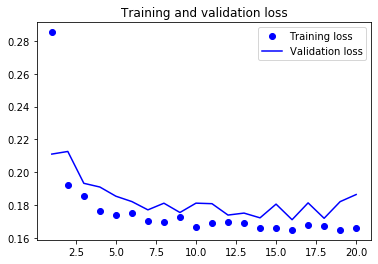

In [239]:
loss = history_1_2.history['loss']
val_loss = history_1_2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [240]:
model_1_2.evaluate(test_gen_2, steps=30)

30/30 [==============================] - 3s 92ms/step - loss: 0.1567


0.15670842450732986

# Two layers of 1D convenet

In [42]:
model_2 = Sequential()
model_2.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.GlobalMaxPooling1D())
model_2.add(layers.Dense(1))

model_2.compile(optimizer=RMSprop(), loss='mae')
history_2 = model_2.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)

Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 0.3315 - val_loss: 0.5216
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.1992 - val_loss: 0.5367
Epoch 3/20
500/500 [==============================] - 52s 103ms/step - loss: 0.1644 - val_loss: 0.5677
Epoch 4/20
500/500 [==============================] - 53s 107ms/step - loss: 0.1420 - val_loss: 0.5722
Epoch 5/20
500/500 [==============================] - 55s 109ms/step - loss: 0.1268 - val_loss: 0.5646
Epoch 6/20
500/500 [==============================] - 58s 116ms/step - loss: 0.1155 - val_loss: 0.5678
Epoch 7/20
500/500 [==============================] - 54s 109ms/step - loss: 0.1068 - val_loss: 0.5746
Epoch 8/20
500/500 [==============================] - 57s 113ms/step - loss: 0.1006 - val_loss: 0.5727
Epoch 9/20
500/500 [==============================] - 55s 110ms/step - loss: 0.0955 - val_loss: 0.5862
Epoch 10/20
500/500 [=======

In [174]:
model_2.save('model_2.h5') 

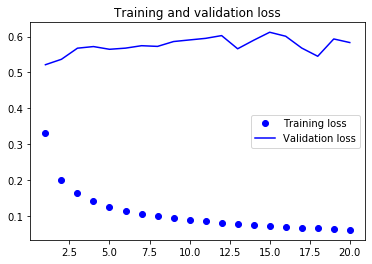

In [175]:
import matplotlib.pyplot as plt
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [187]:
model_2.evaluate(test_gen, steps=30)

30/30 [==============================] - 1s 40ms/step - loss: 0.7885


0.788507649426659

# 1D convnet and GRU model

In [257]:

model_3 = Sequential()
model_3.add(layers.Conv1D(32, 5, activation='relu',
                          input_shape=(None, float_data_1.shape[-1])))
model_3.add(layers.MaxPooling1D(3))
model_3.add(layers.Conv1D(32, 5, activation='relu'))
model_3.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model_3.add(layers.Dense(1))

model_3.summary()
model_3.compile(optimizer=RMSprop(), loss='mae')
history_3 = model_3.fit(train_gen_1,
                        steps_per_epoch=per_epoch,
                        epochs=10,
                        validation_data=val_gen_1,
                        validation_steps=val_steps)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, None, 32)          4192      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_21 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 15,713
Trainable params: 15,713
Non-trainable params: 0
_________________________________________________________________
Train for 200 steps, validate for 40 steps
Epoch 1/10
200/200 [==============================] - 47s 237ms/step - l

In [177]:
model_3.save('model_3.h5') 

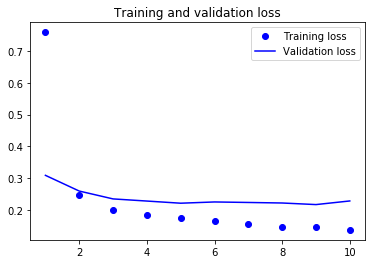

In [258]:
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [260]:
model_3.evaluate(test_gen, steps=30)

30/30 [==============================] - 2s 64ms/step - loss: 0.3772


0.3772366366349161

In [274]:
from tensorflow.keras import regularizers
# learn rate
model_3 = Sequential()
model_3.add(layers.Conv1D(32, 5, activation='relu',
                          input_shape=(None, float_data_1.shape[-1])))
model_3.add(layers.MaxPooling1D(3))
model_3.add(layers.Conv1D(32, 5, activation='relu'))
model_3.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.3))
model_3.add(layers.Dense(1, kernel_regularizer=regularizers.l2(l=0.2)))

model_3.summary()
model_3.compile(optimizer=RMSprop(), loss='mae')
history_3 = model_3.fit(train_gen_1,
                        steps_per_epoch=per_epoch,
                        epochs=20,
                        validation_data=val_gen_1,
                        validation_steps=val_steps)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, None, 32)          4192      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_32 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 15,713
Trainable params: 15,713
Non-trainable params: 0
_________________________________________________________________
Train for 200 steps, validate for 40 steps
Epoch 1/20
200/200 [==============================] - 49s 243ms/step - l

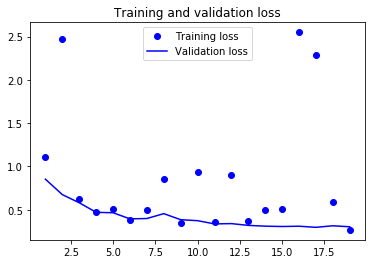

In [279]:
loss = history_3.history['loss'][1:]
val_loss = history_3.history['val_loss'][1:]

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [280]:
model_3.evaluate(test_gen_1, steps=30)

30/30 [==============================] - 2s 76ms/step - loss: 0.7161


0.7160698760300874

# One GRU layer with recurrent dropout

In [64]:
model_4 = Sequential()
model_4.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     input_shape=(None, float_data.shape[-1])))
model_4.add(layers.Dense(1))

model_4.compile(optimizer=RMSprop(), loss='mae')
history_4 = model_4.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)


Train for 500 steps, validate for 40 steps
Epoch 1/20
500/500 [==============================] - 175s 349ms/step - loss: 2.7620 - val_loss: 0.2623
Epoch 2/20
500/500 [==============================] - 174s 347ms/step - loss: 0.2064 - val_loss: 0.2402
Epoch 3/20
500/500 [==============================] - 173s 345ms/step - loss: 0.1919 - val_loss: 0.2186
Epoch 4/20
500/500 [==============================] - 203s 406ms/step - loss: 0.1967 - val_loss: 0.2198
Epoch 5/20
500/500 [==============================] - 177s 353ms/step - loss: 0.2820 - val_loss: 0.2258
Epoch 6/20
500/500 [==============================] - 179s 359ms/step - loss: 0.3132 - val_loss: 0.2149
Epoch 7/20
500/500 [==============================] - 194s 388ms/step - loss: 0.2561 - val_loss: 0.2122
Epoch 8/20
500/500 [==============================] - 193s 387ms/step - loss: 0.6875 - val_loss: 0.2263
Epoch 9/20
500/500 [==============================] - 195s 389ms/step - loss: 0.2115 - val_loss: 0.2200
Epoch 10/20
500/500 [

In [179]:
model_4.save('model_4.h5') 

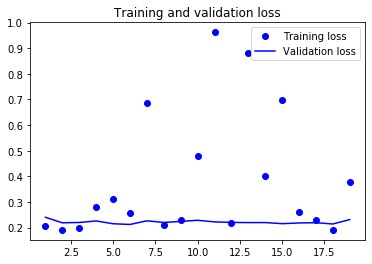

In [74]:
loss = history_4.history['loss'][1:]
val_loss = history_4.history['val_loss'][1:]

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [185]:
model_4.evaluate(test_gen, steps=30)

30/30 [==============================] - 3s 89ms/step - loss: 0.3007


0.30071445753177006

In [72]:
model_5 = Sequential()
model_5.add(layers.Conv1D(64, 5, activation='relu',
                          input_shape=(None, float_data.shape[-1])))
model_5.add(layers.MaxPooling1D(3))
model_5.add(layers.Conv1D(64, 5, activation='relu'))
model_5.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.2))
model_5.add(layers.Dense(1))

model_5.summary()
model_5.compile(optimizer=RMSprop(), loss='mae')
history_5 = model_5.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=temp)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 64)          8384      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 53,953
Trainable params: 53,953
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 182s 365ms/step 

In [181]:
model_5.save('model_5.h5') 

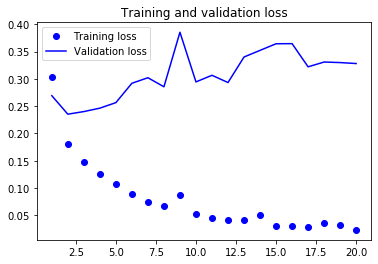

In [182]:
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [184]:
model_5.evaluate(test_gen, steps=30)

30/30 [==============================] - 3s 96ms/step - loss: 0.5721


0.5721043894377847

In [247]:
from tensorflow.keras.regularizers import L1L2

In [248]:
model_6 = Sequential()
model_6.add(layers.LSTM(32,input_shape=(None, float_data_1.shape[-1]), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model_6.add(layers.Dense(1, activation='linear'))

model_6.summary()
model_6.compile(optimizer='adam', loss='mse')
history_6 = model_6.fit(train_gen_1,
                        steps_per_epoch=per_epoch,
                        epochs=20,
                        validation_data=val_gen_1,
                        validation_steps=val_steps)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                7552      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
_________________________________________________________________
Train for 200 steps, validate for 40 steps
Epoch 1/20
200/200 [==============================] - 93s 466ms/step - loss: 0.8299 - val_loss: 0.8657
Epoch 2/20
200/200 [==============================] - 72s 358ms/step - loss: 0.5318 - val_loss: 0.7862
Epoch 3/20
200/200 [==============================] - 70s 350ms/step - loss: 0.3707 - val_loss: 0.7448
Epoch 4/20
200/200 [==============================] - 76s 378ms/step - loss: 0.2559 - val_loss: 0.6594
Epoch 5/20
200/200 [==============================] - 72s 

KeyboardInterrupt: 

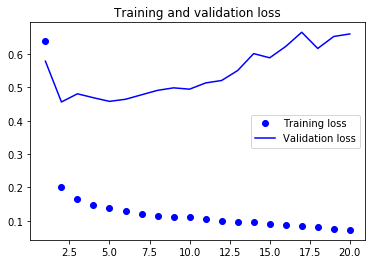

In [190]:
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [191]:
model_6.evaluate(test_gen, steps=30)

30/30 [==============================] - 2s 72ms/step - loss: 1.8846


1.8845635114858548

In [36]:
model_temp = Sequential()
model_temp.add(layers.GRU(32, input_shape=(None, float_data_1.shape[-1])))
model_temp.add(layers.Dense(1))

model_temp.compile(optimzer=RMSprop(), loss='mae', metrics=[RootMeanSquaredError()])
history = model_temp.fit(train_gen_1,
                    steps_per_epoch=per_epoch,
                    epochs=20,
                    validation_data=val_gen_1,
                    validation_steps=val_steps)

Train for 200 steps, validate for 40 steps
Epoch 1/20
200/200 [==============================] - 68s 338ms/step - loss: 0.1982 - root_mean_squared_error: 0.4664 - val_loss: 0.2098 - val_root_mean_squared_error: 0.5984
Epoch 2/20
200/200 [==============================] - 61s 304ms/step - loss: 0.1402 - root_mean_squared_error: 0.4301 - val_loss: 0.1919 - val_root_mean_squared_error: 0.5889
Epoch 3/20
200/200 [==============================] - 60s 300ms/step - loss: 0.1327 - root_mean_squared_error: 0.4274 - val_loss: 0.2021 - val_root_mean_squared_error: 0.6215
Epoch 4/20
200/200 [==============================] - 59s 294ms/step - loss: 0.1281 - root_mean_squared_error: 0.4255 - val_loss: 0.1908 - val_root_mean_squared_error: 0.5925
Epoch 5/20
200/200 [==============================] - 58s 290ms/step - loss: 0.1268 - root_mean_squared_error: 0.4282 - val_loss: 0.1847 - val_root_mean_squared_error: 0.5914
Epoch 6/20
200/200 [==============================] - 65s 326ms/step - loss: 0.124

In [37]:
model_temp.evaluate(test_gen_1, steps=30)

30/30 [==============================] - 3s 92ms/step - loss: 0.1678 - root_mean_squared_error: 0.4976


[0.16779386969283222, 0.4975864]